# Evaluation per quantile level

In [ ]:
import pandas as pd
from src.scoring_functions import compute_scores
from src.load_data import load_predictions
from plotnine import (
    ggplot,
    aes,
    facet_wrap,
    theme,
    theme_bw,
    labs,
    scale_color_manual,
    element_text,
    geom_point,
    geom_line,
    geom_abline,
    element_blank,
    scale_x_continuous,
    scale_y_continuous,
)

In [ ]:
MODEL_COLORS = {
    "Ensemble": "#009E73",
    "LightGBM": "#B30000",
    "LightGBM-NoCovariates": "#B30000",
    "LightGBM-NoCovid": "#B30000",
    "LightGBM-Oracle": "#B30000",
    "LightGBM-Skip": "#B30000",
    "LightGBM-Uncorrected": "#B30000",
    "TSMixer": "#E69F00",
    "TSMixer-NoCovariates": "#E69F00",
    "TSMixer-NoCovid": "#E69F00",
    "TSMixer-Oracle": "#E69F00",
    "TSMixer-Skip": "#E69F00",
    "TSMixer-Uncorrected": "#E69F00",
    "hhh4": "#3C4AAD",
    "hhh4-NoCovid": "#3C4AAD",
    "hhh4-Oracle": "#3C4AAD",
    "hhh4-Skip": "#3C4AAD",
    "hhh4-Uncorrected": "#3C4AAD",
    "Nowcast": "#56B4E9",
    "Historical": "#000000",
    "Persistence": "#80471C",
}

In [ ]:
MODEL_ORDER = [
    "Nowcast",
    "Ensemble",
    "LightGBM",
    "LightGBM-NoCovariates",
    "LightGBM-NoCovid",
    "LightGBM-Oracle",
    "LightGBM-Skip",
    "LightGBM-Uncorrected",
    "TSMixer",
    "TSMixer-NoCovariates",
    "TSMixer-NoCovid",
    "TSMixer-Oracle",
    "TSMixer-Skip",
    "TSMixer-Uncorrected",
    "hhh4",
    "hhh4-NoCovid",
    "hhh4-Oracle",
    "hhh4-Skip",
    "hhh4-Uncorrected",
    "Persistence",
    "Historical",
]

In [ ]:
MAIN_MODELS = ["Ensemble", "LightGBM", "TSMixer", "hhh4", "Historical", "Persistence"]

In [5]:
df = load_predictions()

# Prepare scores

In [6]:
df_scores = compute_scores(df)

In [ ]:
df_scores = df_scores[df_scores["type"] == "quantile"]

In [ ]:
df_scores["level"] = df_scores["age_group"].map(
    lambda x: "national" if x == "00+" else "age"
)
df_scores["level"] = pd.Categorical(
    df_scores["level"], categories=["national", "age"], ordered=True
)

In [ ]:
df_scores = df_scores[df_scores.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df_scores.model.unique()]
df_scores["model"] = pd.Categorical(
    df_scores["model"], categories=model_order, ordered=True
)

In [ ]:
df_qs = (
    df_scores.groupby(["level", "model", "quantile"], observed=True)["score"]
    .mean()
    .reset_index()
)

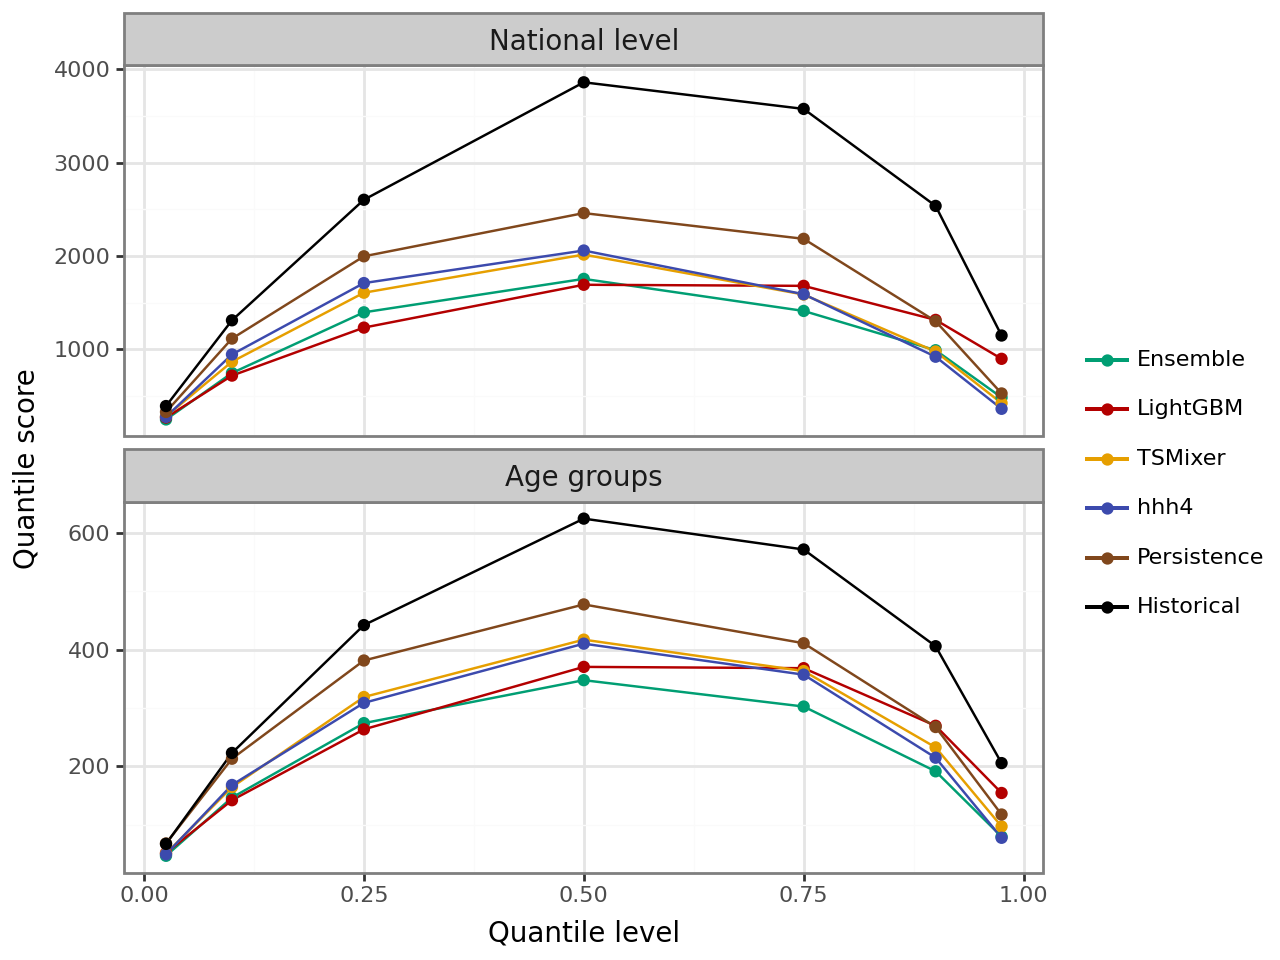

In [ ]:
p = (
    ggplot(df_qs, aes(x="quantile", y="score", color="model"))
    + facet_wrap(
        "level",
        nrow=2,
        scales="free_y",
        labeller=lambda x: ("National level" if x == "national" else "Age groups"),
    )
    + geom_line()
    + geom_point()
    + scale_color_manual(values=MODEL_COLORS)
    + labs(x="Quantile level", y="Quantile score", color="", title="")
    # + scale_x_continuous(breaks=QUANTILES, labels=QUANTILES)
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title_position="top",
        legend_key=element_blank(),
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8),
    )
)
p

In [ ]:
p.save("../figures/qs.pdf", width=160, height=90, units="mm", dpi=600, verbose=False)

# Coverage

In [ ]:
df["covered"] = df.truth <= df.value

In [ ]:
df_coverage = (
    df[df.age_group == "00+"]
    .groupby(["model", "quantile"])["covered"]
    .mean()
    .reset_index()
)

In [ ]:
df_coverage = df_coverage[df_coverage.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df_coverage.model.unique()]
df_coverage["model"] = pd.Categorical(
    df_coverage["model"], categories=model_order, ordered=True
)

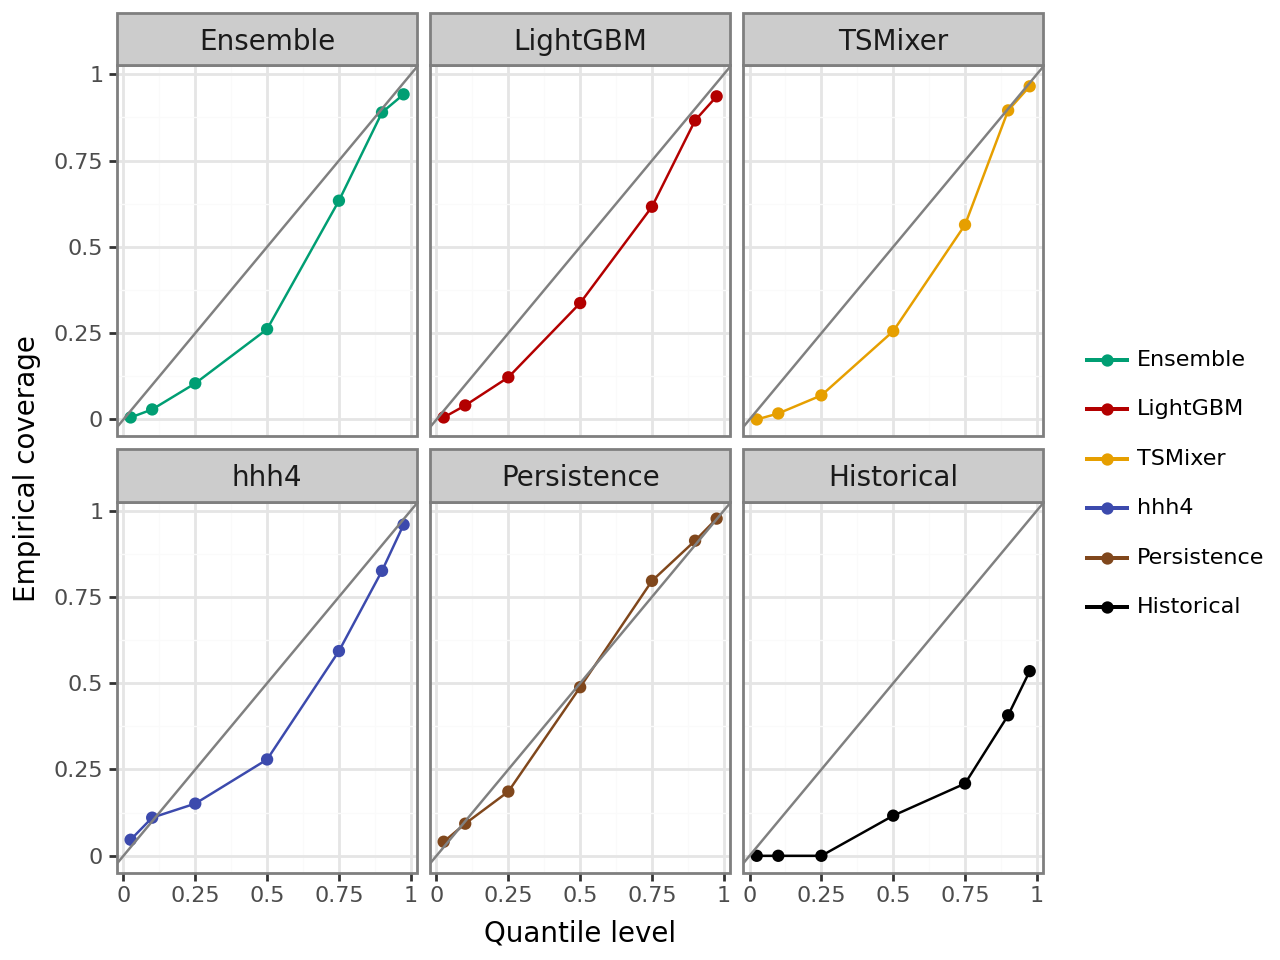

In [ ]:
q = (
    ggplot(df_coverage, aes(x="quantile", y="covered", color="model"))
    + facet_wrap("model")
    + geom_line()
    + geom_point()
    + geom_abline(slope=1, intercept=0, linetype="solid", color="gray")
    + scale_color_manual(values=MODEL_COLORS)
    + labs(x="Quantile level", y="Empirical coverage", color="")
    + scale_x_continuous(
        labels=lambda x: [f"{int(v)}" if v == int(v) else f"{v}" for v in x]
    )
    + scale_y_continuous(
        labels=lambda x: [f"{int(v)}" if v == int(v) else f"{v}" for v in x]
    )
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title_position="top",
        legend_key=element_blank(),
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8),
    )
)
q

In [ ]:
q.save(
    "../figures/quantile_coverage.pdf",
    width=160,
    height=90,
    units="mm",
    dpi=600,
    verbose=False,
)